In [ ]:
import os

In [ ]:
computation = 'cloud'

In [ ]:
if computation == 'local' :
    data_path = '../data/transaction_fraud/'
else :
  from google.colab import drive
  drive.mount('/content/drive')
  data_path = '/content/drive/MyDrive/uco_fraud_detector/data/transaction_fraud/'
print(os.listdir(data_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['bs140513_032310.csv', 'bsNET140513_032310.csv']


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, average_precision_score, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

In [ ]:
data_path = os.path.join(data_path, 'bs140513_032310.csv')
df = pd.read_csv(data_path)

In [ ]:
data_preprocess_path = '/content/drive/MyDrive/uco_fraud_detector/data/data_preprocess'
with open(data_preprocess_path, 'rb') as f:
    data_preprocess = pickle.load(f)

In [ ]:
df = df.replace("'" , "" , regex=True)
df = df.drop(['zipcodeOri' , 'zipMerchant'] , axis = 1)
df['account_frequency'] = df['customer'].apply(lambda x: data_preprocess['customer_frequency_rating_encoder'][x])
df['merchant_frequency'] = df['merchant'].apply(lambda x: data_preprocess['merchant_frequency_rating_encoder'][x])
df = df.rename(columns={'customer': 'account_id', 'merchant': 'merchant_id', 'step': 'time_delta'})
for c in data_preprocess['CATEGORICAL_COLS'] :
  df[c] = data_preprocess[c + '_label_encoder'].transform(df[c])
df[data_preprocess['NUMERICAL_COLS']] = data_preprocess['numerical_scaler'].transform(df[data_preprocess['NUMERICAL_COLS']])
df = df.drop(['account_id'] , axis = 1)
df.head()

,time_delta,age,gender,merchant_id,category,amount,fraud,account_frequency,merchant_frequency
0,-1.860532,4,2,30,12,-0.299276,0,0.340420,-0.182271
1,-1.860532,2,2,30,12,0.016067,0,0.410385,-0.182271
2,-1.860532,4,1,18,12,-0.098742,0,-3.227803,0.765246
3,-1.860532,3,2,30,12,-0.185275,0,0.480350,-0.182271
4,-1.860532,5,2,30,12,-0.019480,0,-0.429197,-0.182271


In [ ]:
X = df.drop('fraud', axis = 1)
Y = df['fraud']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 21)

In [ ]:
def evaluate_model(model,
                   model_name,
                   X_train,
                   Y_train,
                   X_test,
                   Y_test) :
    model.fit(X_train, Y_train)
    y_cap = model.predict(X_test)
    print(f'Evaluation_for {model_name}: ')
    print(classification_report(Y_test, y_cap))
    conf_mat = confusion_matrix(Y_test, y_cap)
    plt.figure(figsize = (5,5))
    sns.heatmap(conf_mat, annot = True,fmt = 'd', cmap = 'plasma')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('y_cap')
    plt.ylabel('y_test')
    plt.show()

    #ROC curve and the area under curve
    y_score = model.predict_proba(X_test)[:,1]
    false_pos_rate , true_pos_rate, thr = roc_curve(Y_test, y_score)
    roc_auc = auc(false_pos_rate , true_pos_rate)

    plt.figure(figsize = (7,5))
    plt.plot(false_pos_rate, true_pos_rate, label = f'ROC Curve, area = {roc_auc:.3f}')
    plt.plot([0,1] , [0,1] , linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

    #Precision-Recall curve Nad AUC
    precision, recall, thresholds = precision_recall_curve(Y_test, y_score)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(7, 5))
    plt.plot(recall, precision, label=f'PR Curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.legend(loc='best')
    plt.show()
    return model

Evaluation_for Ensemble (XGB + RF): 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117560
           1       0.87      0.84      0.85      1369

    accuracy                           1.00    118929
   macro avg       0.93      0.92      0.93    118929
weighted avg       1.00      1.00      1.00    118929



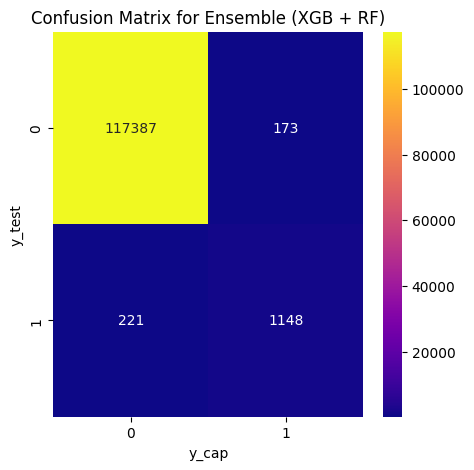

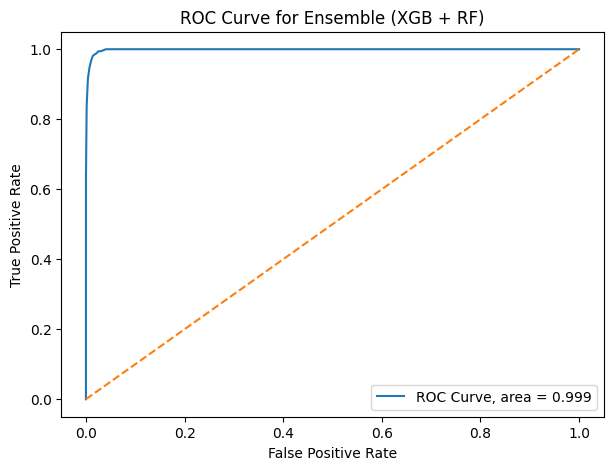

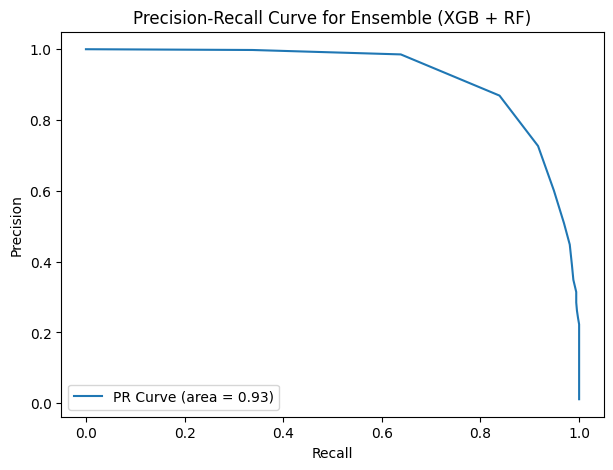

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

base_model = RandomForestClassifier(random_state = 16,
                                    max_depth = 14,
                                    min_samples_leaf = 1,
                                    min_samples_split = 16,
                                    n_estimators = 389)
meta_model = XGBClassifier(eval_metric = 'aucpr',
                           random_state = 16,
                           objective = 'binary:logistic',
                           learning_rate = 0.1,
                           max_depth = 7,
                           n_estimators = 400,
                           subsample = 0.8)

stacked_model = StackingClassifier(estimators = [('rf',base_model)],
                                   final_estimator = meta_model)
model = evaluate_model(stacked_model,
               'Ensemble (XGB + RF)',
               X_train,
               Y_train,
               X_test,
               Y_test)

In [39]:
import pickle
model_save_path = '/content/drive/MyDrive/uco_fraud_detector/models/globalmodel_1'
file = open(model_save_path , 'wb')
pickle.dump(model , file)
print(f'MODEL_SAVED at path {model_save_path}')

MODEL_SAVED at path /content/drive/MyDrive/uco_fraud_detector/models/globalmodel_1


In [41]:
model_save_path = '/content/drive/MyDrive/uco_fraud_detector/models/globalmodel_1'
file = open(model_save_path , 'rb')
model = pickle.load(file)
print(f'MODEL_LOADED from path {model_save_path}')

MODEL_LOADED from path /content/drive/MyDrive/uco_fraud_detector/models/globalmodel_1


In [42]:
model

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=14,
                                                       min_samples_split=16,
                                                       n_estimators=389,
                                                       random_state=16))],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 device=None,
                                                 early_stopping_rounds=None,
                                                 enable_categorical=False,
                                                 eval_metric='au...
                                                 feature_weights=None,
                                                 gamma=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=7, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=400, n_jobs=None,
                                                 num_parallel_tree=None, ...))